In [2]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

from scipy.stats import multivariate_normal, gamma
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

from scipy.stats import gamma
from scipy.special import erfcinv


import git, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [3]:
#Fixed Parameters
#num_parameters = 2
#num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [4]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_C(vectors):
    L = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/(L-1)
    #C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C



For conviencience we will name the pairs as:

* 1: AB
* 2: AC
* 3: BC

## Tension vectors
$$\vec{r}_{1}=\frac{1}{\sqrt{C_{A}+C_{B}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{B}) $$
$$\vec{r}_{2}=\frac{1}{\sqrt{C_{A}+C_{C}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{C}) $$
$$\vec{r}_{3}=\frac{1}{\sqrt{C_{B}+C_{C}}}(\vec{\bar{\theta}}_{B}-\vec{\bar{\theta}}_{C}) $$

In general, if we have N datasets, the total number tension vectors is 

$$L=\frac{N^2-N}{2}=\frac{N(N-1)}{2}$$

## Center of Mass

$$\vec{R}_{CM} = \frac{\sum_i m_{i} \vec{r}_{i}}{\sum_i m_{i}} \, ,$$

where $m_{i}=1$.

## Mass Dispertion Tensor

$$K_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} (\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})$$

$$\mathcal{C}_{ij} = \frac{K_{ij}}{\sum_i m_{i}} \, ,$$

## Inertia Tensor

$$I_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} [\delta_{ij}|\vec{r}_{k}-\vec{R}_{CM}|^{2}-(\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})]$$



Plot this information:

# Real data

In [5]:
import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))

os.chdir(os.path.join(path_global,'montepython_public_old','output'))   
#os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters
names = param_names
labels = names

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


In [6]:
os.path.join(path_git, 'notebooks','PRL', 'figures')
print(path_git)

/home/matias/Documents/PhD/code/multimeter


Center of mass: [-1.1227663  -1.84922768]
Tensor of Inertia: [[1.9538412  2.15803215]
 [2.15803215 5.42756901]]
Eigenvalues: [0.92054284 6.46086737]
Eigenvectors: [[-0.90193956 -0.43186227]
 [ 0.43186227 -0.90193956]]


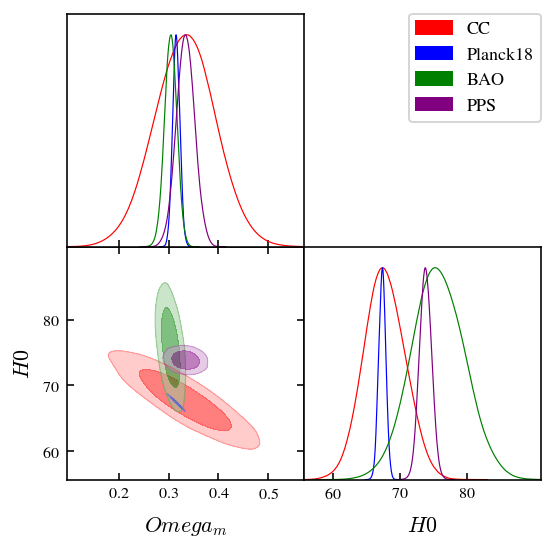

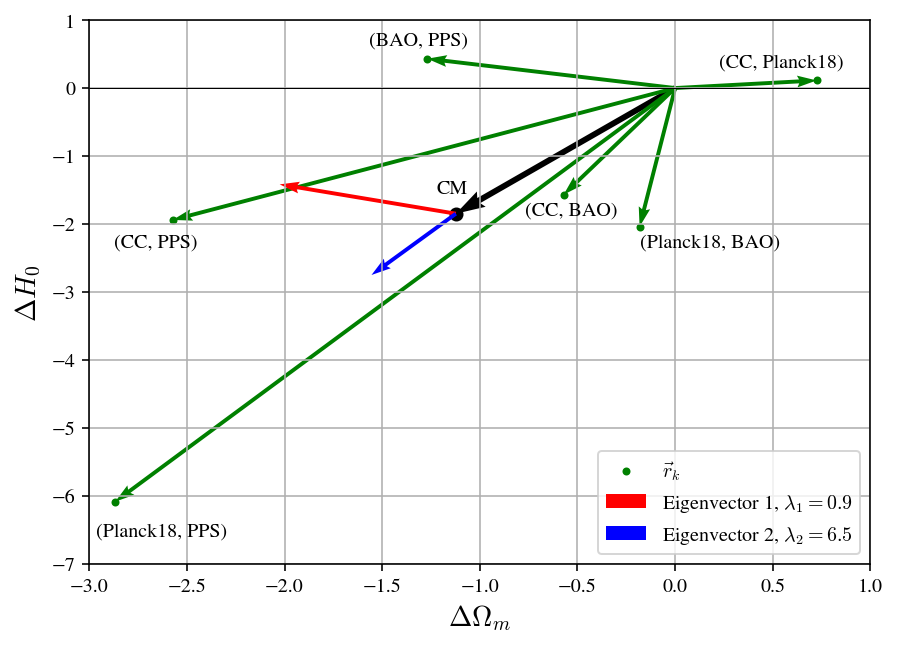

In [7]:
# Plot the distribution of the center of mass   
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm= multivariate_normal(R_CM, C)
ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)

ax.scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.text(R_CM[0]-0.1, R_CM[1]+0.3, 'CM')
ax.text(r_1[0]-0.5, r_1[1]+0.2, '(CC, Planck18)', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, '(CC, BAO)')
ax.text(r_3[0]-0.0, r_3[1]-0.3, '(Planck18, BAO)')
ax.text(r_4[0]-0.3, r_4[1]-0.4, '(CC, PPS)')
ax.text(r_5[0]-0.1, r_5[1]-0.5, '(Planck18, PPS)')
ax.text(r_6[0]-0.3, r_6[1]+0.2, '(BAO, PPS)')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.set_xlim(-3, 1)
ax.set_ylim(-7, 1)
ax.set_xlabel(r'$\Delta \Omega_m$',size=14)

ax.hlines(0, -3, 1, color='black', lw=0.5)
ax.set_ylabel(r'$\Delta H_0$',size=14)
ax.grid()
ax.legend(loc='lower right')


'''
A: CC 
B: Planck18 
C: BAO 
D: PPS

1:AB
2:AC
3:BC
4:AD
5:BD
6:CD
'''

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))

# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
print('Tensor of Inertia: {}'.format(C))




Center of mass: [-1.1227663  -1.84922768]
Tensor of Inertia: [[1.9538412  2.15803215]
 [2.15803215 5.42756901]]


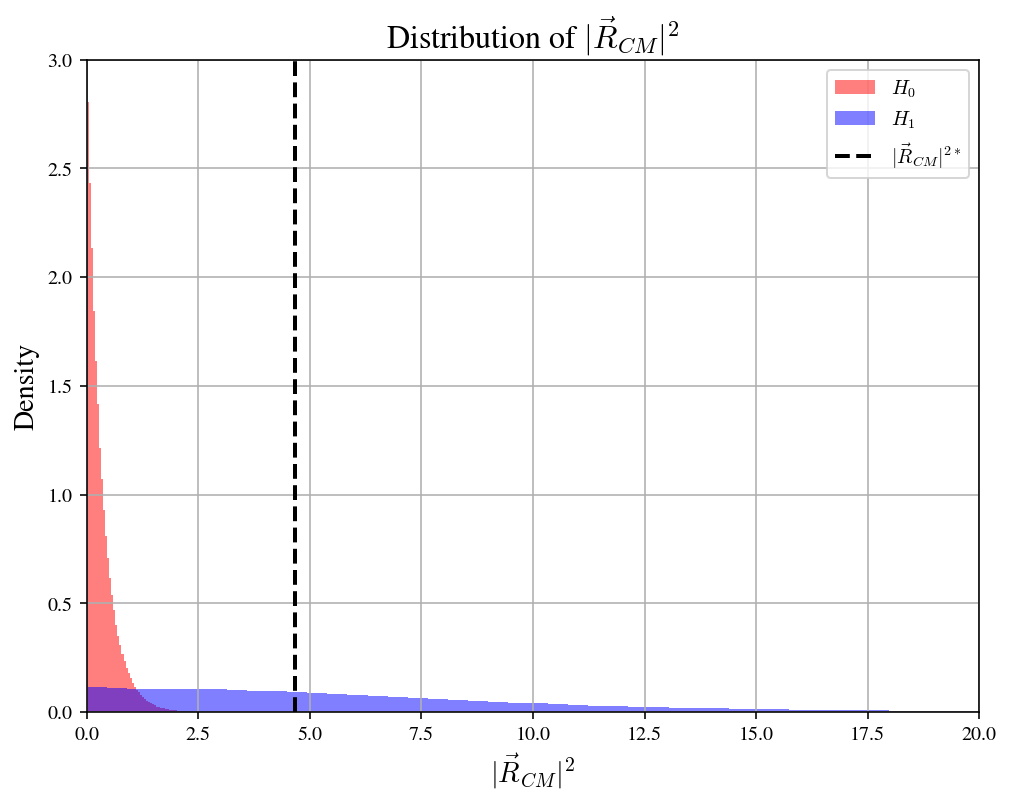

In [9]:
D=2
L=6
samples_size = int(1e6)


#Under H0
squared_RCM_0 = gamma.rvs(a=D/2, scale=2/L, size=samples_size)

#Under H1
samples = np.random.multivariate_normal(mean=R_CM, cov=C, size=(samples_size, L))

#samps_Rcm = np.random.multivariate_normal(mean=R_CM, cov=C/L, size=(samples_size))
samps_Rcm = np.sum(samples, axis=1)/L
squared_RCM_1 = np.sum(samps_Rcm**2, axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(squared_RCM_0, bins=100, density=True, alpha=0.5, color='red', label=r'$H_0$')
ax.hist(squared_RCM_1, bins=100, density=True, alpha=0.5, color='blue', label=r'$H_1$')
ax.vlines(R_CM[0]**2 + R_CM[1]**2, 0, 4, linestyles='dashed',color='black', lw=2, label=r'$|\vec{R}_{CM}|^{2*}$')
ax.legend()
ax.set_xlabel(r'$|\vec{R}_{CM}|^2$', size=14)
ax.set_ylabel('Density', size=14)
ax.set_title(r'Distribution of $|\vec{R}_{CM}|^2$', size=16)
ax.set_xlim(0, 20)
ax.set_ylim(0, 3)
ax.grid()

In [ ]:
print(np.mean(squared_RCM_0), np.mean(squared_RCM_1), R_CM[0]**2 + R_CM[1]**2)
print(np.std(squared_RCM_1))

0.33344589306616806 5.908051235732683 4.680247184725949


In [11]:
import numpy as np

# Simulaciones (por ejemplo, 10,000 muestras de cada hipótesis)
samples_H0 = squared_RCM_0
samples_H1 = squared_RCM_1

# Umbral de decisión para alpha = 0.05 (rechazo si media > threshold)
threshold = np.percentile(samples_H0, 95)  # percentil 95 de H0

# Error tipo I: rechazar H0 cuando H0 es cierta
error_tipo_I = np.mean(samples_H0 > threshold)

# Error tipo II: NO rechazar H0 cuando H1 es cierta
error_tipo_II = np.mean(samples_H1 <= threshold)

# Poder del test: 1 - beta
poder = 1 - error_tipo_II

print(f"Error tipo I (α): {error_tipo_I:.3f}")
print(f"Error tipo II (β): {error_tipo_II:.3f}")
print(f"Poder (1 - β): {poder:.3f}")


Error tipo I (α): 0.050
Error tipo II (β): 0.111
Poder (1 - β): 0.889


In [12]:
n_sigma = np.zeros(samples_size)
# Calcular el número de sigma para cada muestra de H1
from scipy.special import erfcinv
for i in range(samples_size):
    PTE = gamma.sf(samples_H1[i], a=D/2, scale=2/L)
    n_sigma[i] = np.sqrt(2) * erfcinv(PTE)

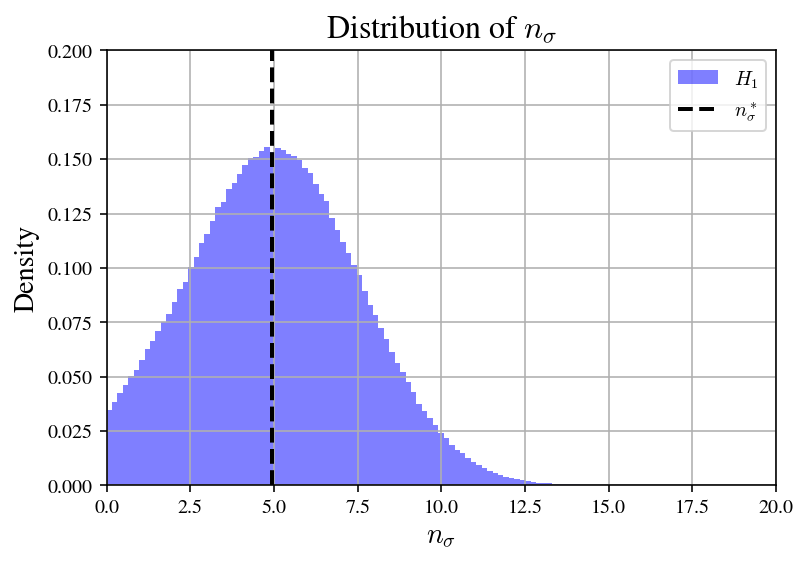

In [13]:
PTE_0 = gamma.sf(R_CM[0]**2 + R_CM[1]**2, a=D/2, scale=2/L)
n_sigma_0 = np.sqrt(2) * erfcinv(PTE_0)


plt.vlines(n_sigma_0, 0, 0.2, linestyles='dashed', color='black', lw=2, label=r'$n_\sigma^*$')
plt.hist(n_sigma, bins=100, density=True, alpha=0.5, color='blue', label=r'$H_1$')
plt.xlabel(r'$n_\sigma$', size=14)
plt.ylabel('Density', size=14)
plt.title(r'Distribution of $n_\sigma$', size=16)
plt.legend()
plt.xlim(0, 20)
plt.ylim(0, 0.2)
plt.grid()

In [14]:
print('Mean: {:.3g}'.format(np.mean(n_sigma)))
print('Std: {:.3g}'.format(np.std(n_sigma)))

print('Median: {:.3g}'.format(np.median(n_sigma)))
lower_bound = np.percentile(n_sigma, 68.3)
print('1-sigma lower bound: {:.3g}'.format(lower_bound))
lower_2sigma_bound = np.percentile(n_sigma, 95)
print('2-sigma lower bound: {:.3g}'.format(lower_2sigma_bound))

Mean: 5.08
Std: 2.46
Median: 5.03
1-sigma lower bound: 6.25
2-sigma lower bound: 9.25


In [16]:
R_CM[0]**2 + R_CM[1]**2 - (C[0, 0] + C[1, 1])/L

3.45001214859914

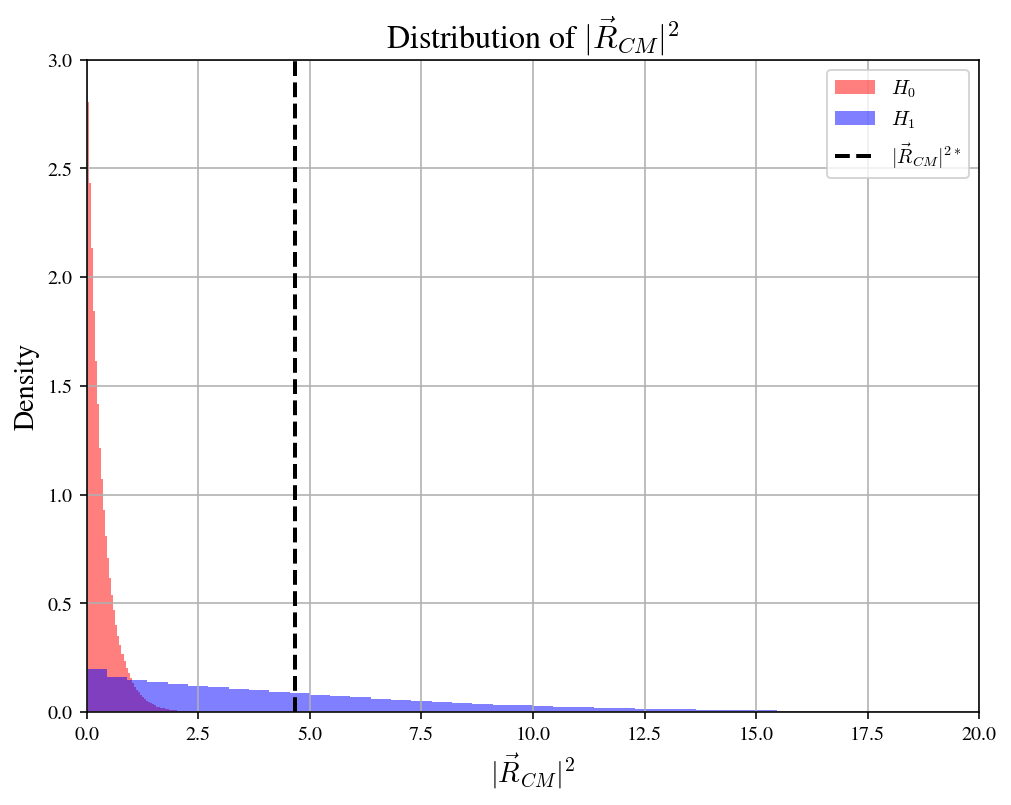

In [36]:
D=2
L=6
samples_size = int(1e6)

#Under H1
samples = np.random.multivariate_normal(mean=R_CM*np.sqrt(1-(C[0, 0] + C[1, 1])/(L*np.linalg.norm(R_CM)**2)), cov=C, size=(samples_size, L))

#samps_Rcm = np.random.multivariate_normal(mean=R_CM, cov=C/L, size=(samples_size))
samps_Rcm = np.sum(samples, axis=1)/L
squared_RCM_1 = np.sum(samps_Rcm**2, axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(squared_RCM_0, bins=100, density=True, alpha=0.5, color='red', label=r'$H_0$')
ax.hist(squared_RCM_1, bins=100, density=True, alpha=0.5, color='blue', label=r'$H_1$')
ax.vlines(R_CM[0]**2 + R_CM[1]**2, 0, 4, linestyles='dashed',color='black', lw=2, label=r'$|\vec{R}_{CM}|^{2*}$')
ax.legend()
ax.set_xlabel(r'$|\vec{R}_{CM}|^2$', size=14)
ax.set_ylabel('Density', size=14)
ax.set_title(r'Distribution of $|\vec{R}_{CM}|^2$', size=16)
ax.set_xlim(0, 20)
ax.set_ylim(0, 3)
ax.grid()

In [38]:
print(np.linalg.norm(R_CM)**2, R_CM[0]**2 + R_CM[1]**2)

4.680247184725949 4.680247184725949


In [48]:
print(np.mean(squared_RCM_1), R_CM[0]**2 + R_CM[1]**2)
print(np.std(squared_RCM_1))

4.673637148288917 4.680247184725949
4.1250072497109835


In [40]:
samples_H1 = squared_RCM_1
n_sigma = np.zeros(samples_size)
# Calcular el número de sigma para cada muestra de H1
from scipy.special import erfcinv
for i in range(samples_size):
    PTE = gamma.sf(samples_H1[i], a=D/2, scale=2/L)
    n_sigma[i] = np.sqrt(2) * erfcinv(PTE)

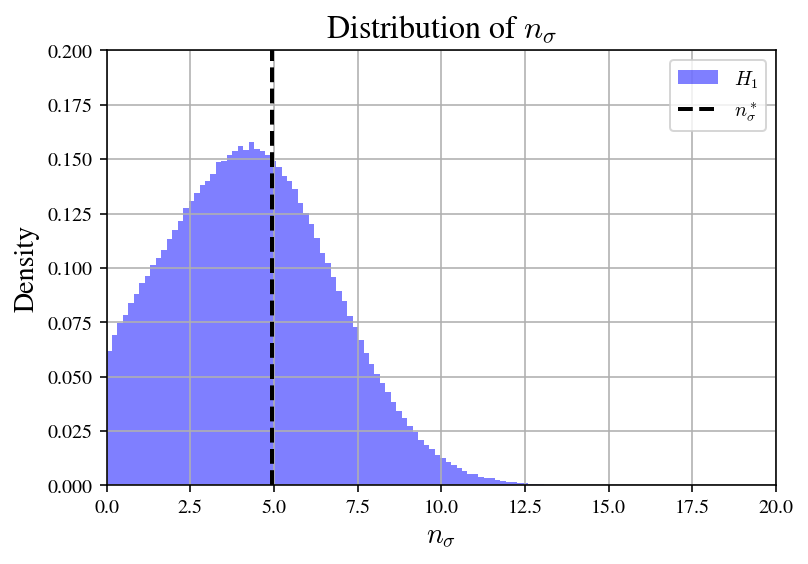

In [41]:
PTE_0 = gamma.sf(R_CM[0]**2 + R_CM[1]**2, a=D/2, scale=2/L)
n_sigma_0 = np.sqrt(2) * erfcinv(PTE_0)


plt.vlines(n_sigma_0, 0, 0.2, linestyles='dashed', color='black', lw=2, label=r'$n_\sigma^*$')
plt.hist(n_sigma, bins=100, density=True, alpha=0.5, color='blue', label=r'$H_1$')
plt.xlabel(r'$n_\sigma$', size=14)
plt.ylabel('Density', size=14)
plt.title(r'Distribution of $n_\sigma$', size=16)
plt.legend()
plt.xlim(0, 20)
plt.ylim(0, 0.2)
plt.grid()

In [ ]:
print('Mean: {:.3g}'.format(np.mean(n_sigma)))
print('Std: {:.3g}'.format(np.std(n_sigma)))

print('Median: {:.3g}'.format(np.median(n_sigma)))
lower_bound = np.percentile(n_sigma, 68.3)
print('1-sigma lower bound: {:.3g}'.format(lower_bound))
lower_2sigma_bound = np.percentile(n_sigma, 95)
print('2-sigma lower bound: {:.3g}'.format(lower_2sigma_bound))

4.9357748142817535
Mean: 4.38
Std: 2.38
Median: 4.27
1-sigma lower bound: 5.49
2-sigma lower bound: 8.49
